In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

def data_generate_setting2(p, T, rho, seed=1234):
    """Generates data using factor models with 2 factors and a smooth time-varying factor loading and residuals from i.i.d
    multivariate normal distribution with cross-sectional dependence in a synthetic covariance of residuals.
    Copyright (C) 2023 Ali Habibnia <habibnia@vt.edu> & Jalal Etesami

    Args:
        p: Dimension of the portfolio.
        T: Sample size.
        rho: Autoregressive coefficient in the factor loadings that controls the
             departure from constant factor loading.

      The value 200 later on in the for loop is a predefined constant and this value determines the "burn-in" period,
       or the number of initial time steps that are calculated but then discarded when constructing the final time series!

    Returns:
        Y: A (p, T) matrix of asset returns.
        r_cov: The covariance matrix of Y.
        s_cov: The cross-sectional covariance matrix of the residuals.

      Reference:
        Qingliang Fan, Ruike Wu, Yanrong Yang, Wei Zhong,
        Time-varying minimum variance portfolio,
        Journal of Econometrics,
        2022,
        105339,
        ISSN 0304-4076,
        https://doi.org/10.1016/j.jeconom.2022.08.007.
        (https://www.sciencedirect.com/science/article/pii/S0304407622001646
    """
    np.random.seed(seed)
    subt = np.arange(1, T+1) / T  # generate scaled time

    loading1 = np.zeros((p, T))
    loading2 = np.zeros((p, T))
    for subi in range(p):
        z = rho * ((3 + np.random.randn()) * subt + np.random.randn() * np.sin(4 * np.pi * subt)) + np.random.randn()
        z2 = rho * ((3 + np.random.randn()) * subt + np.random.randn() * np.sin(4 * np.pi * subt) + (np.random.randn() * subt) ** 2) + np.random.randn()
        loading1[subi, :] = z
        loading2[subi, :] = z2

    # cross-sectional dependence in residuals
    s_cov = np.zeros((p, p))
    for i in range(p):
        for j in range(i + 1, p):
            s_cov[i, j] = ((0.5) ** abs(j - i))
            s_cov[j, i] = s_cov[i, j]
    s_cov = s_cov + np.eye(p)
    r_cov = np.matmul(np.column_stack((loading1[:, T-1], loading2[:, T-1])), np.column_stack((loading1[:, T-1], loading2[:, T-1])).T) + s_cov

    F1_set = np.zeros(T + 200)
    F2_set = np.zeros(T + 200)

    F1_t0 = np.random.randn()
    F2_t0 = np.random.randn()

    for j in range(T + 200):
        F1_t = 0.6 * F1_t0 + multivariate_normal.rvs(mean=0, cov=0.64, size=1)
        F1_set[j] = F1_t
        F1_t0 = F1_t
        F2_t = 0.3 * F2_t0 + multivariate_normal.rvs(mean=0, cov=0.91, size=1)
        F2_set[j] = F2_t
        F2_t0 = F2_t

    # We remove the first 200 observations to account for the potential non-stationarity caused by the initial conditions
    F = np.vstack((F1_set[200:200 + T], F2_set[200:200 + T])) # Transpose F

    x_k = multivariate_normal.rvs(mean=np.zeros(p), cov=s_cov, size=T).T
    fa_part = np.zeros((p, T))
    for qq in range(T):
        B1_temp = np.column_stack((loading1[:, qq], loading2[:, qq]))
        fa_part[:, qq] = B1_temp.dot(F[:, qq]) # Multiply by the qq-th column of F

    Y = fa_part + x_k
    Y_df = pd.DataFrame(Y.T)

    return Y_df, r_cov, s_cov

In [ ]:
# Example usage with specific values for p, T, and rho
p = 50
T = 500
rho = 1
returns = data_generate_setting2(p, T, rho)
returns[0].head(3)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.092925,1.687495,0.946904,1.627346,-1.916113,0.263360,-2.474607,-2.244052,-2.613533,-1.503547,...,2.440630,-0.668548,-1.592205,-0.503813,-2.156852,-1.563221,-2.844384,-1.601942,-1.518464,1.370699
1,0.182542,-1.959499,0.358436,-0.757671,-0.017857,-1.104273,0.521460,0.242214,0.749245,-0.872277,...,-0.331939,1.699990,1.215654,0.643870,0.752730,1.047432,0.021863,0.588875,-0.037371,0.701457
2,1.811901,-0.802144,-1.237535,-1.440801,0.005372,0.071128,-0.374253,-0.974516,0.273855,-3.139650,...,-4.844708,-2.471221,0.559260,3.384033,0.829812,0.586547,-0.561100,0.874302,0.460320,-0.414856


<Axes: >

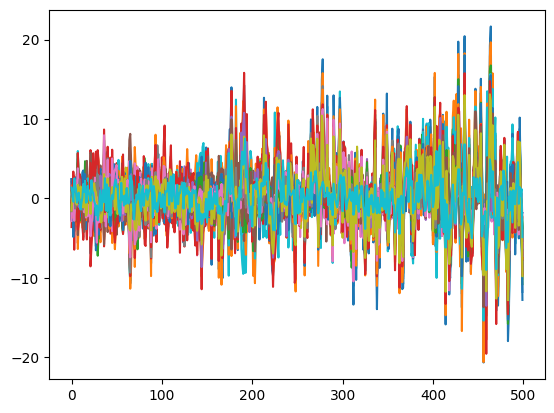

In [ ]:
returns[0].plot(legend = False)